# Exploring the critical community size of an SIR model

Use multiple nodes with no connection to identify the critical community size and its dependence on disease and demographic parameters

In [5]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import os
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Agents_In_Patch

from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch

%load_ext line_profiler

f"{np.__version__=}"

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


"np.__version__='1.26.4'"

In [ ]:
%%capture

nticks = 50*365
npatches = 61
pops = np.logspace(3, 6, npatches)
scenario = pd.DataFrame({
    "name": [str(i) for i in range(npatches)],
    "population": pops
})

#np.random.seed(5)  # Ensure reproducibility
nsims = 200
R0_samples = np.random.uniform(3, 16, nsims)
infmean_samples = 5+np.random.gamma(2, 10, nsims)
cbr_samples = 10+np.random.gamma(2, 20, nsims)
i = 0
outputs = np.zeros((nsims, nticks, npatches))
# Create a folder to store the outputs
output_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'laser-generic-outputs', 'CCSSIRoutputs2'))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for R0, infmean, cbr in zip(R0_samples, infmean_samples, cbr_samples):
    parameters = PropertySet({"seed": np.random.randint(0, 1000000),
                            "nticks": nticks,
                            "verbose": True, 
                            "beta": R0/infmean,
                            "inf_mean": infmean,
                            "cbr": cbr, 
                            "importation_period": 180, 
                            "importation_end": 20*365
                            })

    mu = ((1+parameters.cbr/1000)**(1/365)-1) 

    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Agents_In_Patch,
    ]   

    #Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    #Want to see how connectivity drives correlation over time.
    for j in range(npatches):
        set_initial_susceptibility_in_patch(model, j, 1/R0+.1/R0*np.random.normal())

    model.run()
    outputs[i, :, :] = model.patches.cases
    np.save(f"{output_folder}/CCSSIRoutputs_{i}.npy", outputs[i, :, :])
    i+=1



In [4]:
params_df = pd.DataFrame({
    'R0': R0_samples,
    'infmean': infmean_samples,
    'cbr': cbr_samples
})

params_df.to_csv(os.path.join(output_folder, 'params.csv'), index=False)

Bad pipe message: %s [b'\xe9\xbaU\xd6\xd6\x00\xc4y{\xbc\x06,\x8f\xd4']
Bad pipe message: %s [b'\xb1\xf6\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0', b'\x04\xc0']
Bad pipe message: %s [b'\x06\xc0\x07\xc0']
Bad pipe message: %s [b'\t\xc0\n\xc0\x0b\xc0\x0c']
Bad pipe message: %s [b'\xcd\xa3\x18\xc0\x8e.\x01\x8a\xad

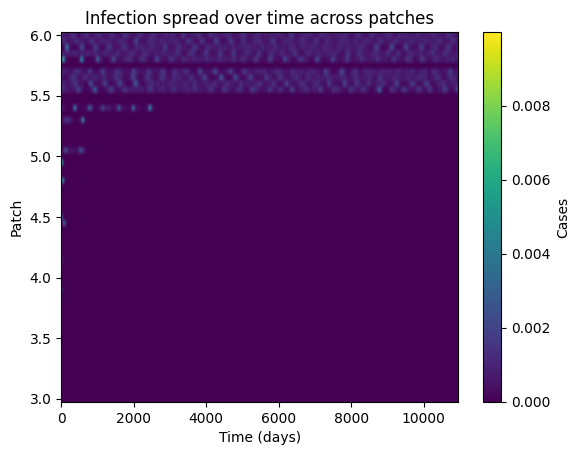

In [43]:
plt.imshow(outputs[26, 7300:, :].T/pops[:, np.newaxis], aspect='auto', origin='lower')
plt.colorbar(label='Cases')
plt.xlabel('Time (days)')
plt.ylabel('Patch')
plt.yticks(range(0, npatches, 10), np.log10(pops[::10]))
plt.title('Infection spread over time across patches')
plt.show()

In [44]:
cbr_samples

array([38.45967534, 24.19479029, 88.69766788, 47.13799266, 51.45973827,
       41.62923858, 29.8582311 , 56.55513934, 38.77736425, 65.05225879,
       36.22120382, 60.91098257, 95.86607072, 49.74669651, 96.33752715,
       24.5764733 , 63.90440946, 67.9837993 , 96.94026542, 94.0148105 ,
       60.87249036, 80.75889121, 98.07242253, 78.92002112, 96.31647792,
       95.11151835, 58.54137291, 72.79153847, 34.38797063, 54.96187779,
       89.28993511, 66.17856562, 42.35628834, 29.82314022, 38.54841615,
       29.99940518, 38.70243442, 50.6864008 , 23.43188247, 87.09685575,
       52.30482094, 65.38951716, 70.89072118, 30.62736052, 26.61660895,
       32.52257702, 98.89797787, 28.36121936, 53.81247372, 90.00498777,
       66.74205222, 21.40269371, 91.09620648, 50.73181306, 33.41841662,
       46.97438645, 67.53185055, 23.0196144 , 71.46468171, 68.80851203,
       38.30351377, 54.08142082, 35.48119708, 21.70638716, 66.71358992,
       55.62856356, 87.36453184, 35.92445232, 55.24792377, 73.39

In [ ]:
params_df = pd.DataFrame({
    'R0': R0_samples,
    'infmean': infmean_samples,
    'cbr': cbr_samples
})

params_df.to_csv('CCSSIRoutputs/params.csv', index=False)

In [4]:
CCS1 = []
CCS2 = []

for sim in range(nsims):
    end_output = outputs[sim, -1, :]
    zero_pops = pops[end_output == 0]
    nonzero_pops = pops[end_output != 0]
    
    if len(zero_pops) > 0:
        CCS2.append(np.max(zero_pops))
    else:
        CCS2.append(None)
    
    if len(nonzero_pops) > 0:
        CCS1.append(np.min(nonzero_pops))
    else:
        CCS1.append(None)

results_df = pd.DataFrame({
    'largest_zero_pop': CCS2,
    'smallest_nonzero_pop': CCS1
})

print(results_df)

     largest_zero_pop  smallest_nonzero_pop
0       112201.845430          89125.093813
1       112201.845430          70794.578438
2       354813.389234          79432.823472
3        22387.211386          15848.931925
4      1000000.000000                   NaN
..                ...                   ...
195     562341.325190          63095.734448
196    1000000.000000                   NaN
197     141253.754462          31622.776602
198      10000.000000           6309.573445
199    1000000.000000                   NaN

[200 rows x 2 columns]


Bad pipe message: %s [b'\xd7\x1b\x92\x1bD~\xfeM\x84u\xea\xcbo\xe9\xac\x86\xecR\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03']
Bad pipe message: %s [b'\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08']
Bad pipe message: %s [b"\x89d_\xe4\x1a\x10\xa1=\xd1\x8c\x9e\x03\xde_\x10'%\x02\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x0

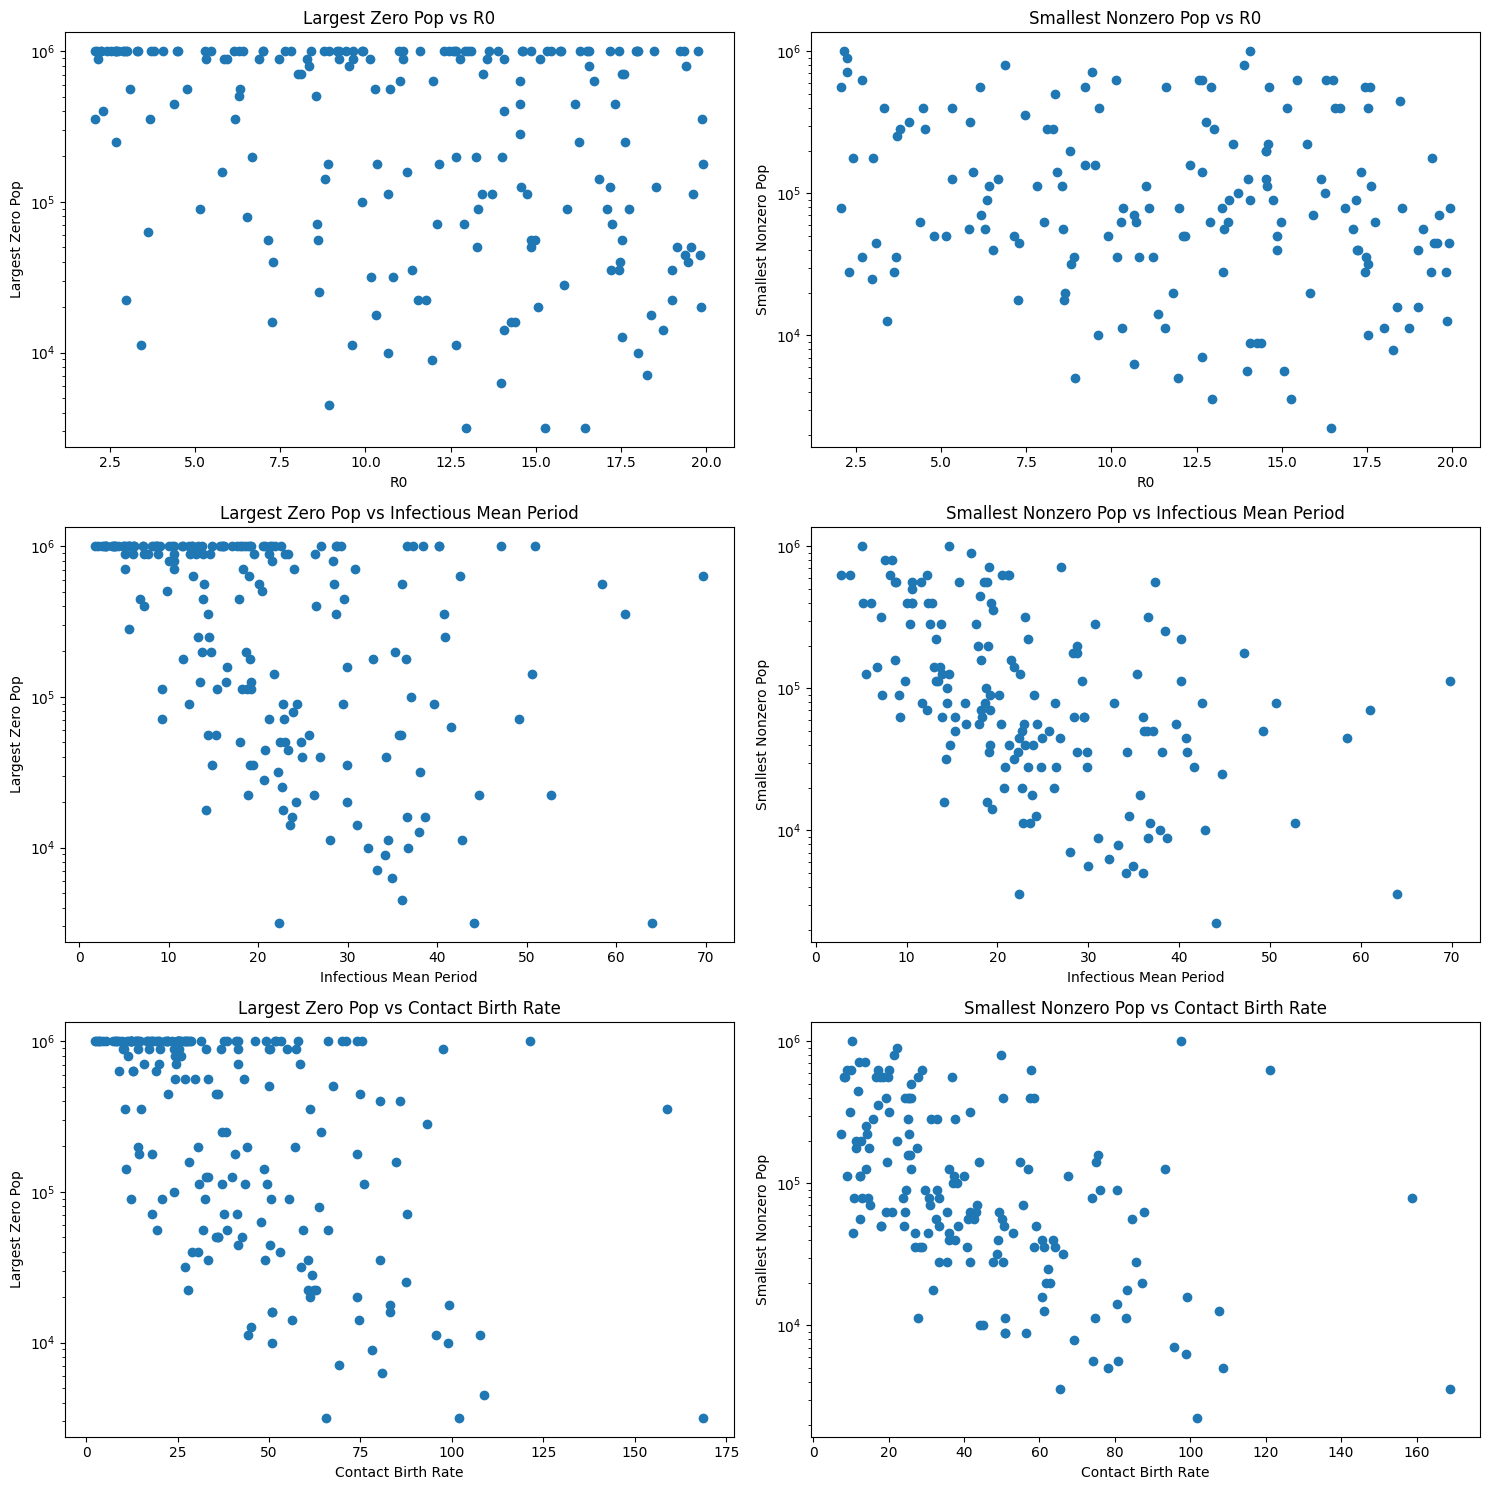

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot largest_zero_pop against R0, infmean, and cbr
axs[0, 0].scatter(params_df['R0'], results_df['largest_zero_pop'])
axs[0, 0].set_xlabel('R0')
axs[0, 0].set_ylabel('Largest Zero Pop')
axs[0, 0].set_title('Largest Zero Pop vs R0')
axs[0, 0].set_yscale('log')

axs[1, 0].scatter(params_df['infmean'], results_df['largest_zero_pop'])
axs[1, 0].set_xlabel('Infectious Mean Period')
axs[1, 0].set_ylabel('Largest Zero Pop')
axs[1, 0].set_title('Largest Zero Pop vs Infectious Mean Period')
axs[1, 0].set_yscale('log')

axs[2, 0].scatter(params_df['cbr'], results_df['largest_zero_pop'])
axs[2, 0].set_xlabel('Contact Birth Rate')
axs[2, 0].set_ylabel('Largest Zero Pop')
axs[2, 0].set_title('Largest Zero Pop vs Contact Birth Rate')
axs[2, 0].set_yscale('log')

# Plot smallest_nonzero_pop against R0, infmean, and cbr
axs[0, 1].scatter(params_df['R0'], results_df['smallest_nonzero_pop'])
axs[0, 1].set_xlabel('R0')
axs[0, 1].set_ylabel('Smallest Nonzero Pop')
axs[0, 1].set_title('Smallest Nonzero Pop vs R0')
axs[0, 1].set_yscale('log')

axs[1, 1].scatter(params_df['infmean'], results_df['smallest_nonzero_pop'])
axs[1, 1].set_xlabel('Infectious Mean Period')
axs[1, 1].set_ylabel('Smallest Nonzero Pop')
axs[1, 1].set_title('Smallest Nonzero Pop vs Infectious Mean Period')
axs[1, 1].set_yscale('log')

axs[2, 1].scatter(params_df['cbr'], results_df['smallest_nonzero_pop'])
axs[2, 1].set_xlabel('Contact Birth Rate')
axs[2, 1].set_ylabel('Smallest Nonzero Pop')
axs[2, 1].set_title('Smallest Nonzero Pop vs Contact Birth Rate')
axs[2, 1].set_yscale('log')

plt.tight_layout()
plt.show()

/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_3510/402221576.py:11: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax1.set_zscale('log')
/Users/kevinmccarthy/Documents/GitHub/laser-generic/.venv/lib/python3.11/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/var/folders/1b/yq6gx3hj51jf_v98kwv057xh0000gn/T/ipykernel_3510/402221576.py:22: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax2.set_zscale('log')


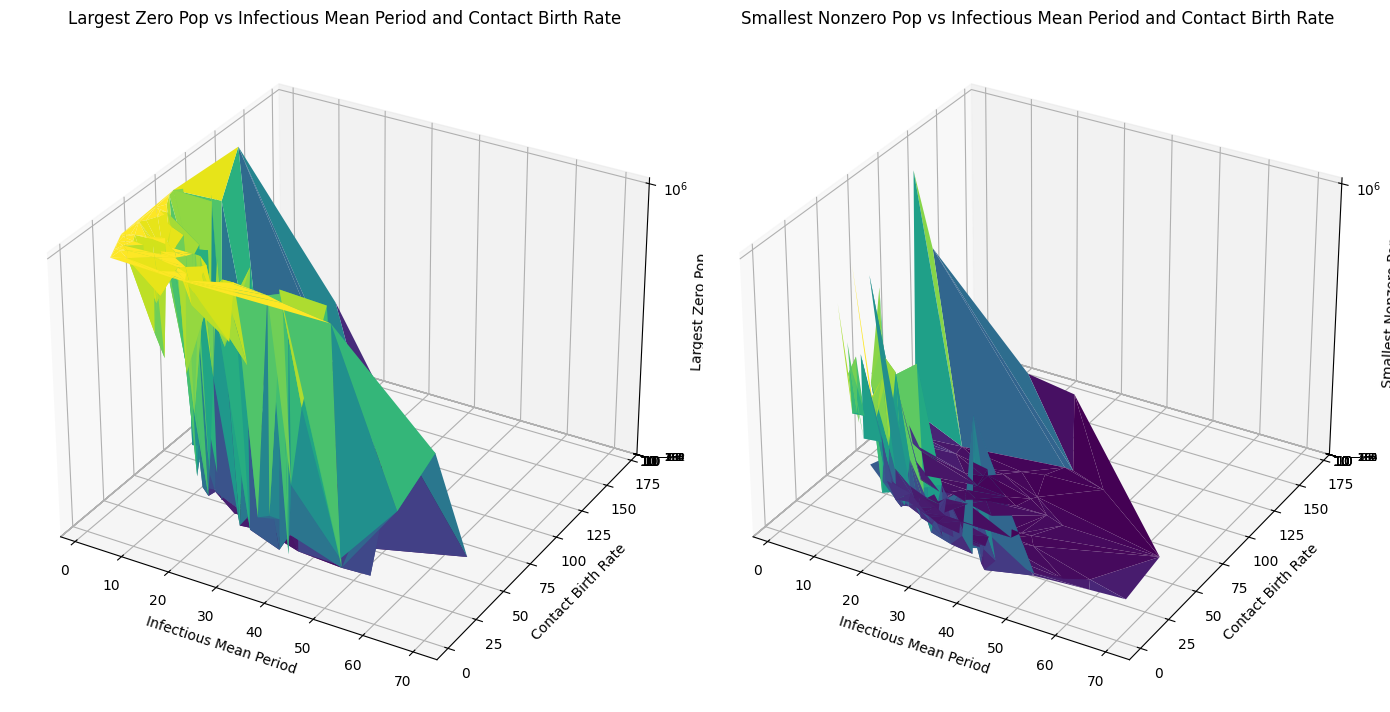

Bad pipe message: %s [b'\xdb\xef8\xca\xd7\xb9\x8c1\xd7r\xfek\xe3w\x8a]\xb8\xdd']
Bad pipe message: %s [b'\xc4L\xe2\x85jS`\xad\x831\xb6\xa6\x80-\xaalA\xa7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00']
Bad pipe message: %s [b'\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 7))

# Surface plot for largest_zero_pop
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(params_df['infmean'], params_df['cbr'], results_df['largest_zero_pop'], cmap='viridis')
ax1.set_xlabel('Infectious Mean Period')
ax1.set_ylabel('Contact Birth Rate')
ax1.set_zlabel('Largest Zero Pop')
ax1.set_zscale('log')

ax1.set_title('Largest Zero Pop vs Infectious Mean Period and Contact Birth Rate')

# Surface plot for smallest_nonzero_pop
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(params_df['infmean'], params_df['cbr'], results_df['smallest_nonzero_pop'], cmap='viridis')
ax2.set_xlabel('Infectious Mean Period')
ax2.set_ylabel('Contact Birth Rate')
ax2.set_zlabel('Smallest Nonzero Pop')
ax2.set_title('Smallest Nonzero Pop vs Infectious Mean Period and Contact Birth Rate')
ax2.set_zscale('log')
plt.tight_layout()
plt.show()

NameError: name 'results_df' is not defined

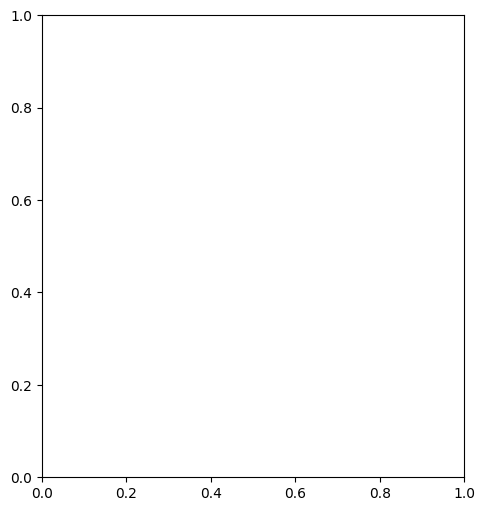

In [3]:
# Calculate alpha
alpha = infmean_samples * cbr_samples

# Plot largest_zero_pop against alpha
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(1/alpha, results_df['largest_zero_pop'])
plt.xlabel('Alpha (inf_mean * cbr)')
plt.ylabel('Largest Zero Pop')
plt.title('Largest Zero Pop vs Alpha')
plt.yscale('log')

# Plot smallest_nonzero_pop against alpha
plt.subplot(1, 2, 2)
plt.scatter(1/alpha, results_df['smallest_nonzero_pop'])
plt.xlabel('Alpha (inf_mean * cbr)')
plt.ylabel('Smallest Nonzero Pop')
plt.title('Smallest Nonzero Pop vs Alpha')
#plt.yscale('line')

plt.tight_layout()
plt.show()

(array([ 7.,  6., 13., 13., 10., 12., 14., 15.,  6.,  8., 11.,  8.,  6.,
         4., 12.,  4.,  6.,  7.,  4.,  3.,  3.,  6.,  2.,  3.,  3.,  3.,
         0.,  1.,  3.,  2.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 12.43959232,  15.7661712 ,  19.09275008,  22.41932896,
         25.74590784,  29.07248672,  32.3990656 ,  35.72564448,
         39.05222336,  42.37880224,  45.70538112,  49.03196   ,
         52.35853888,  55.68511776,  59.01169664,  62.33827552,
         65.6648544 ,  68.99143327,  72.31801215,  75.64459103,
         78.97116991,  82.29774879,  85.62432767,  88.95090655,
         92.27748543,  95.60406431,  98.93064319, 102.25722207,
        105.58380095, 108.91037983, 112.23695871, 115.56353759,
        118.89011647, 122.21669535, 125.54327423, 128.86985311,
        132.19643198, 135.52301086, 138.84958974, 142.17616862,
        145.5027475 , 148.82932638, 152.15590526, 155.48248414,
        158.

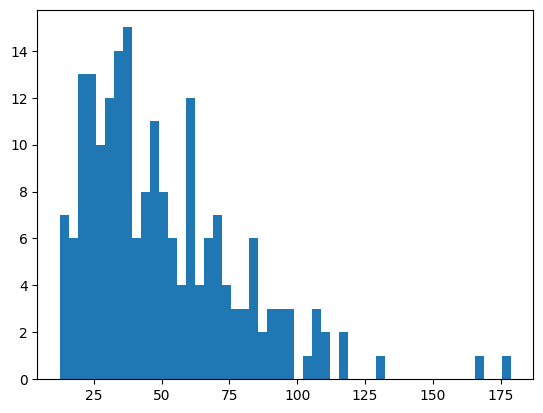

In [23]:
plt.hist(10+cbr_samples, bins=50)

In [27]:
output_folder = "..\..\laser-generic-outputs\CCSSIRoutputs"

['twopatchSIRoutputs', 'CCSSIRoutputs']
